In [6]:
# --- Cell 1: Convert PDF pages to images with fixed size (H x W = 100 x 80) ---

import os
from pdf2image import convert_from_path
from PIL import Image

# ---- Config ----
PDF_PATH = "head.pdf"

# Note: you asked for height x width, so we set them explicitly:
PAGE_HEIGHT = 1000
PAGE_WIDTH  = 800            # => number of columns per page will be 80
MAIN_FOLDER = "dataegde"

os.makedirs(MAIN_FOLDER, exist_ok=True)

def pdf_to_pages(pdf_path, out_root, page_height, page_width):
    pages = convert_from_path(pdf_path)  # returns PIL Images
    for i, page in enumerate(pages):
        page_folder = os.path.join(out_root, f"page_{i}")
        os.makedirs(page_folder, exist_ok=True)
        # PIL resize expects (width, height)
        page_resized = page.convert("RGB").resize((page_width, page_height), Image.BILINEAR)
        out_path = os.path.join(page_folder, f"page_{i}.jpg")
        page_resized.save(out_path, "JPEG", quality=95)
        print(f"[OK] Saved page_{i} as {page_width}x{page_height} -> {out_path}")

pdf_to_pages(PDF_PATH, MAIN_FOLDER, PAGE_HEIGHT, PAGE_WIDTH)
print(f"\nSet page size: {PAGE_HEIGHT}x{PAGE_WIDTH} (H×W). Columns per page = {PAGE_WIDTH}.")


[OK] Saved page_0 as 800x1000 -> dataegde\page_0\page_0.jpg
[OK] Saved page_1 as 800x1000 -> dataegde\page_1\page_1.jpg
[OK] Saved page_2 as 800x1000 -> dataegde\page_2\page_2.jpg
[OK] Saved page_3 as 800x1000 -> dataegde\page_3\page_3.jpg
[OK] Saved page_4 as 800x1000 -> dataegde\page_4\page_4.jpg
[OK] Saved page_5 as 800x1000 -> dataegde\page_5\page_5.jpg
[OK] Saved page_6 as 800x1000 -> dataegde\page_6\page_6.jpg
[OK] Saved page_7 as 800x1000 -> dataegde\page_7\page_7.jpg
[OK] Saved page_8 as 800x1000 -> dataegde\page_8\page_8.jpg
[OK] Saved page_9 as 800x1000 -> dataegde\page_9\page_9.jpg
[OK] Saved page_10 as 800x1000 -> dataegde\page_10\page_10.jpg
[OK] Saved page_11 as 800x1000 -> dataegde\page_11\page_11.jpg
[OK] Saved page_12 as 800x1000 -> dataegde\page_12\page_12.jpg
[OK] Saved page_13 as 800x1000 -> dataegde\page_13\page_13.jpg
[OK] Saved page_14 as 800x1000 -> dataegde\page_14\page_14.jpg
[OK] Saved page_15 as 800x1000 -> dataegde\page_15\page_15.jpg
[OK] Saved page_16 as 

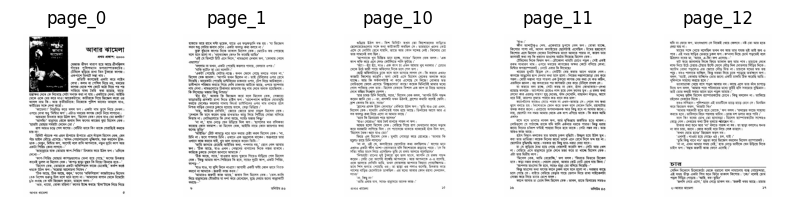

In [7]:
# --- Cell 2: Display a few sample pages ---

import os
from PIL import Image
import matplotlib.pyplot as plt

def show_sample_pages(root, max_pages=5):
    page_dirs = sorted([d for d in os.listdir(root) if d.startswith("page_") and os.path.isdir(os.path.join(root, d))])
    sample = page_dirs[:max_pages]
    if not sample:
        print("No pages found.")
    else:
        plt.figure(figsize=(2*len(sample), 3))
        for idx, pd in enumerate(sample, 1):
            img_path = os.path.join(root, pd, f"{pd}.jpg")
            if os.path.exists(img_path):
                img = Image.open(img_path)
                plt.subplot(1, len(sample), idx)
                plt.imshow(img)
                plt.axis("off")
                plt.title(pd)
        plt.show()

show_sample_pages(MAIN_FOLDER, max_pages=5)


In [8]:
# --- Cell 3 (updated): Slice pages into 1px columns; drop near-white columns robustly ---

import os
import shutil
import numpy as np
from PIL import Image

# Tunables for "full white" detection
WHITE_THRESH = 250       # pixel >= 250 (0..255) counts as white-ish
WHITE_COVERAGE = 0.995   # at least 99.5% of pixels must be white-ish to discard

def is_near_full_white(pil_img, thr=WHITE_THRESH, coverage=WHITE_COVERAGE):
    """
    Return True if the column is effectively 'full white', tolerating JPEG artifacts.
    Works for L/RGB images. Treats a pixel as white if all channels >= thr.
    Declares the column white if white pixel ratio >= coverage.
    """
    # Convert to RGB to unify logic
    if pil_img.mode != "RGB":
        pil_img = pil_img.convert("RGB")
    arr = np.asarray(pil_img, dtype=np.uint8)

    # white-ish if ALL channels >= thr
    white_mask = (arr >= thr).all(axis=2)  # shape (H, 1)
    white_ratio = white_mask.mean()
    return white_ratio >= coverage

def slice_columns_for_page(page_folder, page_height, page_width, save_format="JPEG"):
    img_path = os.path.join(page_folder, f"{os.path.basename(page_folder)}.jpg")
    if not os.path.exists(img_path):
        print(f"[WARN] Missing image at {img_path}")
        return

    img = Image.open(img_path).convert("RGB")
    w, h = img.size  # (width, height)

    cols_dir = os.path.join(page_folder, "columns")
    # clean previous results to avoid leftovers
    if os.path.isdir(cols_dir):
        shutil.rmtree(cols_dir)
    os.makedirs(cols_dir, exist_ok=True)

    saved = 0
    discarded = 0
    for x in range(w):
        col = img.crop((x, 0, x+1, h))  # 1-pixel wide
        if is_near_full_white(col):
            discarded += 1
            continue
        out_ext = "png" if save_format.upper() == "PNG" else "jpg"
        out_path = os.path.join(cols_dir, f"column_{saved}.{out_ext}")
        if save_format.upper() == "PNG":
            col.save(out_path, "PNG")
        else:
            # JPEG is fine; PNG is safer if you want 100% lossless columns
            col.save(out_path, "JPEG", quality=95, subsampling=0)
        saved += 1

    print(f"[OK] {os.path.basename(page_folder)}: kept {saved}, discarded {discarded} near-white columns (of {w}).")

def slice_all_pages(root, page_height, page_width, save_format="JPEG"):
    page_dirs = sorted(
        d for d in os.listdir(root)
        if d.startswith("page_") and os.path.isdir(os.path.join(root, d))
    )
    for pd in page_dirs:
        slice_columns_for_page(os.path.join(root, pd), page_height, page_width, save_format=save_format)

# Run slicer (use save_format='PNG' if you want to avoid JPEG artifacts entirely)
slice_all_pages(MAIN_FOLDER, PAGE_HEIGHT, PAGE_WIDTH, save_format="JPEG")


[OK] page_0: kept 572, discarded 228 near-white columns (of 800).
[OK] page_1: kept 582, discarded 218 near-white columns (of 800).
[OK] page_10: kept 574, discarded 226 near-white columns (of 800).
[OK] page_11: kept 573, discarded 227 near-white columns (of 800).
[OK] page_12: kept 577, discarded 223 near-white columns (of 800).
[OK] page_13: kept 575, discarded 225 near-white columns (of 800).
[OK] page_14: kept 575, discarded 225 near-white columns (of 800).
[OK] page_15: kept 575, discarded 225 near-white columns (of 800).
[OK] page_16: kept 574, discarded 226 near-white columns (of 800).
[OK] page_17: kept 575, discarded 225 near-white columns (of 800).
[OK] page_18: kept 575, discarded 225 near-white columns (of 800).
[OK] page_19: kept 578, discarded 222 near-white columns (of 800).
[OK] page_2: kept 572, discarded 228 near-white columns (of 800).
[OK] page_20: kept 576, discarded 224 near-white columns (of 800).
[OK] page_3: kept 572, discarded 228 near-white columns (of 800).

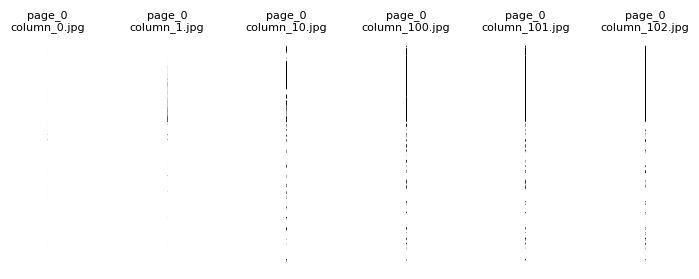

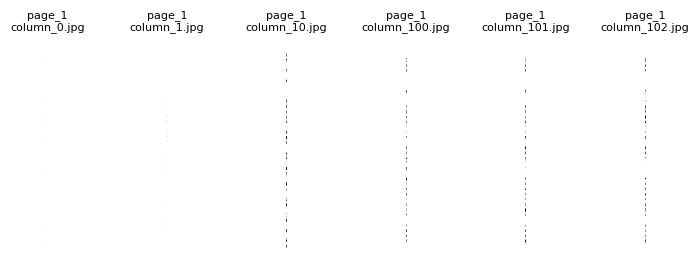

In [9]:
# --- Cell 4: Show first few columns for a couple of pages ---

import os
from PIL import Image
import matplotlib.pyplot as plt

def show_sample_columns(root, pages=2, cols_each=5):
    page_dirs = sorted([d for d in os.listdir(root) if d.startswith("page_") and os.path.isdir(os.path.join(root, d))])[:pages]
    for pd in page_dirs:
        cols_dir = os.path.join(root, pd, "columns")
        if not os.path.isdir(cols_dir):
            print(f"[WARN] No columns folder for {pd}")
            continue
        col_files = sorted([f for f in os.listdir(cols_dir) if f.lower().endswith(".jpg")])[:cols_each]
        if not col_files:
            print(f"[INFO] No non-white columns saved for {pd}")
            continue

        plt.figure(figsize=(1.5*len(col_files), 3))
        for i, fn in enumerate(col_files, 1):
            img = Image.open(os.path.join(cols_dir, fn))
            plt.subplot(1, len(col_files), i)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"{pd}\n{fn}", fontsize=8)
        plt.show()

show_sample_columns(MAIN_FOLDER, pages=2, cols_each=6)


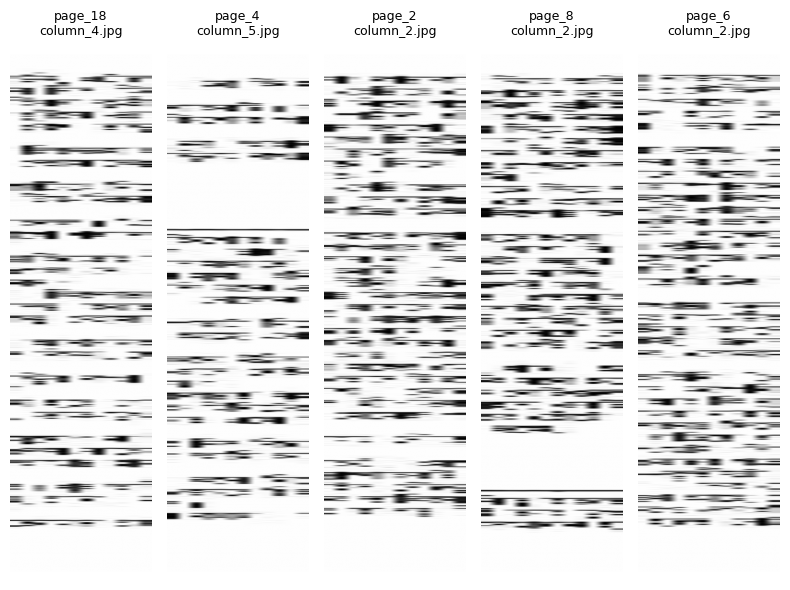


===== Pixel intensity values (top → bottom) =====

page_18 / column_4.jpg  (height=1000)
first 20: [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255]
...middle (every 50th): [255, 221, 254, 254, 254, 117, 254, 227, 237, 92, 254, 255, 28, 114, 254, 254, 255, 255, 254, 254]
last 20: [254, 254, 254, 254, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255]

page_4 / column_5.jpg  (height=1000)
first 20: [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255]
...middle (every 50th): [255, 254, 134, 254, 255, 254, 254, 146, 254, 245, 250, 254, 248, 248, 254, 55, 223, 249, 254, 254]
last 20: [254, 254, 254, 254, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255]

page_2 / column_2.jpg  (height=1000)
first 20: [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255]
...middle (every 50th): [255, 0, 2

In [14]:
# --- Cell: Show simple side-by-side random columns with their pixel values (top→bottom) ---

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

MAIN_FOLDER = "dataload"
NUM_COLUMNS_TO_SHOW = 5   # how many random columns total to display

def get_all_column_paths(root):
    """Collect (page_name, column_path) for every column image."""
    paths = []
    for d in sorted(os.listdir(root)):
        page_dir = os.path.join(root, d)
        cols_dir = os.path.join(page_dir, "columns")
        if d.startswith("page_") and os.path.isdir(cols_dir):
            for f in os.listdir(cols_dir):
                if f.lower().endswith((".jpg", ".png")):
                    paths.append((d, os.path.join(cols_dir, f)))
    return paths

def extract_intensity_vector(img_path):
    """Return grayscale intensity vector (H,) top→bottom."""
    arr = np.array(Image.open(img_path).convert("L"))
    if arr.ndim == 1:
        return arr
    elif arr.ndim == 2:
        return arr[:, 0]
    return arr.reshape(-1)

def show_random_columns_simple(root, k=5):
    all_cols = get_all_column_paths(root)
    if not all_cols:
        print("No column images found. Run the slicing step first.")
        return

    chosen = random.sample(all_cols, min(k, len(all_cols)))

    # --- show column images side-by-side (widened for visibility) ---
    fig, axes = plt.subplots(1, len(chosen), figsize=(1.6*len(chosen), 6))
    if len(chosen) == 1:
        axes = [axes]

    for ax, (page_name, col_path) in zip(axes, chosen):
        col_img = Image.open(col_path).convert("L")
        h = col_img.height
        # enlarge visually so you can see it
        vis = col_img.resize((12, h), Image.NEAREST)
        ax.imshow(vis, cmap="gray", aspect="auto")
        ax.axis("off")
        ax.set_title(f"{page_name}\n{os.path.basename(col_path)}", fontsize=9)

    plt.tight_layout()
    plt.show()

    # --- print pixel values for each column ---
    print("\n===== Pixel intensity values (top → bottom) =====")
    for page_name, col_path in chosen:
        intens = extract_intensity_vector(col_path).astype(int)
        H = len(intens)
        print(f"\n{page_name} / {os.path.basename(col_path)}  (height={H})")

        # show limited number for readability
        if H <= 60:
            print("values:", intens.tolist())
        else:
            print("first 20:", intens[:20].tolist())
            print("...middle (every 50th):", intens[20:H-20:50].tolist())
            print("last 20:", intens[-20:].tolist())

# run
show_random_columns_simple(MAIN_FOLDER, k=NUM_COLUMNS_TO_SHOW)


# Similarity % = ( 1 − Mean Absolute Difference / 255 ) × 100

In [22]:
# --- Cell: For each page in dataedge, compute per-page column-to-column similarity matrix and save CSV ---

import os
import re
import numpy as np
import pandas as pd
from PIL import Image

MAIN_FOLDER = "dataegde"   # <-- your folder

def natkey(name):
    """Natural sort key: splits digits so 'column_10' > 'column_2' correctly."""
    return [int(s) if s.isdigit() else s.lower() for s in re.split(r'(\d+)', name)]

def load_column_vectors(columns_dir):
    """
    Load all column images from columns_dir.
    Returns: names (sorted), vecs (list of 1D arrays, top→bottom intensities)
    """
    files = [f for f in os.listdir(columns_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    files.sort(key=natkey)
    names, vecs = [], []
    for f in files:
        p = os.path.join(columns_dir, f)
        arr = np.array(Image.open(p).convert("L"))
        # shapes can be (H,) or (H,1) — ensure (H,)
        if arr.ndim == 2:
            arr = arr[:, 0]
        else:
            arr = arr.reshape(-1)
        vecs.append(arr.astype(np.float32))
        names.append(f)
    return names, vecs

def pixel_similarity_percent(a, b):
    """
    Pixel-wise similarity using Mean Absolute Difference:
      similarity% = (1 - mean(|a - b|)/255) * 100, clipped to [0,100].
    """
    if a.shape != b.shape:
        m = min(len(a), len(b))
        a = a[:m]
        b = b[:m]
    mad = float(np.mean(np.abs(a - b)))
    sim = (1.0 - mad / 255.0) * 100.0
    return float(np.clip(sim, 0.0, 100.0))

def similarity_matrix(vecs):
    """Build an NxN similarity matrix (percentages)."""
    n = len(vecs)
    M = np.zeros((n, n), dtype=np.float32)
    for i in range(n):
        for j in range(n):
            if i == j:
                M[i, j] = 100.0  # self-similarity
            else:
                M[i, j] = pixel_similarity_percent(vecs[i], vecs[j])
    return M

def process_page(page_dir):
    cols_dir = os.path.join(page_dir, "columns")
    if not os.path.isdir(cols_dir):
        print(f"[SKIP] {page_dir}: no columns folder.")
        return

    names, vecs = load_column_vectors(cols_dir)
    n = len(vecs)
    if n < 2:
        print(f"[INFO] {page_dir}: not enough columns (found {n}).")
        return

    M = similarity_matrix(vecs)
    df = pd.DataFrame(M, index=names, columns=names)

    out_csv = os.path.join(page_dir, "column_similarity_matrix.csv")
    df.to_csv(out_csv, index=True)
    print(f"[CSV] {os.path.basename(page_dir)} → {out_csv}  (matrix {n}×{n})")

def process_all_pages(root):
    pages = sorted(d for d in os.listdir(root)
                   if d.startswith("page_") and os.path.isdir(os.path.join(root, d)))
    if not pages:
        print("No pages found in", root)
        return
    for p in pages:
        process_page(os.path.join(root, p))

# run
process_all_pages(MAIN_FOLDER)


[CSV] page_0 → dataegde\page_0\column_similarity_matrix.csv  (matrix 572×572)
[CSV] page_1 → dataegde\page_1\column_similarity_matrix.csv  (matrix 582×582)
[CSV] page_10 → dataegde\page_10\column_similarity_matrix.csv  (matrix 574×574)
[CSV] page_11 → dataegde\page_11\column_similarity_matrix.csv  (matrix 573×573)
[CSV] page_12 → dataegde\page_12\column_similarity_matrix.csv  (matrix 577×577)
[CSV] page_13 → dataegde\page_13\column_similarity_matrix.csv  (matrix 575×575)
[CSV] page_14 → dataegde\page_14\column_similarity_matrix.csv  (matrix 575×575)
[CSV] page_15 → dataegde\page_15\column_similarity_matrix.csv  (matrix 575×575)
[CSV] page_16 → dataegde\page_16\column_similarity_matrix.csv  (matrix 574×574)
[CSV] page_17 → dataegde\page_17\column_similarity_matrix.csv  (matrix 575×575)
[CSV] page_18 → dataegde\page_18\column_similarity_matrix.csv  (matrix 575×575)
[CSV] page_19 → dataegde\page_19\column_similarity_matrix.csv  (matrix 578×578)
[CSV] page_2 → dataegde\page_2\column_simila

# 📊 Cell — Confusion-matrix style similarity heatmap per page

In [23]:
# Generate confusion-matrix-style heatmaps (with values) per page from saved CSVs

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ROOT = "dataegde"

def natkey(name):
    return [int(s) if s.isdigit() else s.lower() for s in re.split(r'(\d+)', name)]

def load_matrix_from_matrix_csv(csv_path):
    df = pd.read_csv(csv_path, index_col=0)
    # ensure numeric
    df = df.apply(pd.to_numeric, errors="coerce")
    # natural sort both axes
    df = df.loc[sorted(df.index, key=natkey), sorted(df.columns, key=natkey)]
    return df

def load_matrix_from_pairs_csv(csv_path):
    # Expect columns: page,column_a,column_b,similarity_percent
    pairs = pd.read_csv(csv_path)
    # collect names and sort naturally
    names = sorted(
        set(pairs["column_a"]).union(set(pairs["column_b"])),
        key=natkey
    )
    idx = {name: i for i, name in enumerate(names)}
    n = len(names)
    # start with 100 on diagonal, NaN elsewhere
    M = np.full((n, n), np.nan, dtype=np.float32)
    np.fill_diagonal(M, 100.0)
    # fill symmetric similarities
    for _, row in pairs.iterrows():
        a, b, s = row["column_a"], row["column_b"], row["similarity_percent"]
        i, j = idx[a], idx[b]
        M[i, j] = float(s)
        M[j, i] = float(s)
    # any remaining NaN (missing pairs) -> 0 (or keep NaN if you prefer blank)
    M = np.nan_to_num(M, nan=0.0)
    df = pd.DataFrame(M, index=names, columns=names)
    return df

def plot_confusion(df, title, out_path, annotate_limit=120):
    names = list(df.index)
    n = len(names)

    # build figure size proportional to n but capped
    side = max(6, min(0.3 * n, 18))
    fig, ax = plt.subplots(figsize=(side, side))
    im = ax.imshow(df.values, cmap="viridis", vmin=0, vmax=100)

    # ticks: show compact labels (column number only if present)
    short_labels = [re.sub(r'\D', '', s) or s for s in names]
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(short_labels, rotation=90, fontsize=7)
    ax.set_yticklabels(short_labels, fontsize=7)

    ax.set_title(title, fontsize=10)
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Similarity (%)")

    # annotate values inside cells for reasonable sizes
    if n <= annotate_limit:
        vals = df.values
        # Choose contrasting text color for readability
        for i in range(n):
            for j in range(n):
                v = vals[i, j]
                txt_color = "white" if v < 50 else "black"
                ax.text(j, i, f"{v:.1f}", ha="center", va="center", fontsize=6, color=txt_color)

    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close(fig)
    print(f"[IMG] Saved: {out_path} (size {n}×{n}, annotated: {'yes' if n <= annotate_limit else 'no'})")

def process_all_pages(root):
    pages = sorted(
        d for d in os.listdir(root)
        if d.startswith("page_") and os.path.isdir(os.path.join(root, d))
    )
    if not pages:
        print("No pages found in", root)
        return

    for page in pages:
        page_dir = os.path.join(root, page)
        mtx_csv = os.path.join(page_dir, "column_similarity_matrix.csv")
        pair_csv = os.path.join(page_dir, "column_pair_similarity.csv")

        if os.path.exists(mtx_csv):
            df = load_matrix_from_matrix_csv(mtx_csv)
        elif os.path.exists(pair_csv):
            df = load_matrix_from_pairs_csv(pair_csv)
        else:
            print(f"[SKIP] {page}: no similarity CSV found.")
            continue

        out_png = os.path.join(page_dir, f"{page}_similarity_confusion.png")
        plot_confusion(df, title=f"{page} — Column Similarity (%)", out_path=out_png, annotate_limit=120)

# Run it
process_all_pages(ROOT)


[IMG] Saved: dataegde\page_0\page_0_similarity_confusion.png (size 572×572, annotated: no)
[IMG] Saved: dataegde\page_1\page_1_similarity_confusion.png (size 582×582, annotated: no)
[IMG] Saved: dataegde\page_10\page_10_similarity_confusion.png (size 574×574, annotated: no)
[IMG] Saved: dataegde\page_11\page_11_similarity_confusion.png (size 573×573, annotated: no)
[IMG] Saved: dataegde\page_12\page_12_similarity_confusion.png (size 577×577, annotated: no)
[IMG] Saved: dataegde\page_13\page_13_similarity_confusion.png (size 575×575, annotated: no)
[IMG] Saved: dataegde\page_14\page_14_similarity_confusion.png (size 575×575, annotated: no)
[IMG] Saved: dataegde\page_15\page_15_similarity_confusion.png (size 575×575, annotated: no)
[IMG] Saved: dataegde\page_16\page_16_similarity_confusion.png (size 574×574, annotated: no)
[IMG] Saved: dataegde\page_17\page_17_similarity_confusion.png (size 575×575, annotated: no)
[IMG] Saved: dataegde\page_18\page_18_similarity_confusion.png (size 575×5

In [1]:
# Generate mini 10x10 confusion-matrix-style heatmaps (with values) per page from saved CSVs

import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ROOT = "dataegde"
RANDOM_SEED = 42   # set None for fully random each run

if RANDOM_SEED is not None:
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

def natkey(name):
    return [int(s) if s.isdigit() else s.lower() for s in re.split(r'(\d+)', name)]

def load_matrix_from_matrix_csv(csv_path):
    df = pd.read_csv(csv_path, index_col=0)
    df = df.apply(pd.to_numeric, errors="coerce")
    # natural sort both axes
    df = df.loc[sorted(df.index, key=natkey), sorted(df.columns, key=natkey)]
    return df

def load_matrix_from_pairs_csv(csv_path):
    # Expect columns: page,column_a,column_b,similarity_percent
    pairs = pd.read_csv(csv_path)
    names = sorted(set(pairs["column_a"]) | set(pairs["column_b"]), key=natkey)
    idx = {n: i for i, n in enumerate(names)}
    n = len(names)
    M = np.full((n, n), np.nan, dtype=np.float32)
    np.fill_diagonal(M, 100.0)
    for _, row in pairs.iterrows():
        a, b, s = row["column_a"], row["column_b"], row["similarity_percent"]
        i, j = idx[a], idx[b]
        M[i, j] = float(s)
        M[j, i] = float(s)
    M = np.nan_to_num(M, nan=0.0)
    return pd.DataFrame(M, index=names, columns=names)

def pick_10(df):
    names = list(df.index)
    k = min(10, len(names))
    # sample without replacement
    chosen = random.sample(names, k)
    # order them naturally for a neat mini matrix
    chosen.sort(key=natkey)
    return df.loc[chosen, chosen]

def plot_confusion(df, title, out_path):
    n = len(df)
    fig, ax = plt.subplots(figsize=(max(5, 0.7*n), max(5, 0.7*n)))
    im = ax.imshow(df.values, cmap="viridis", vmin=0, vmax=100)

    # compact labels: show only numeric suffix when present
    pretty = [re.sub(r'\D', '', s) or s for s in df.index]
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(pretty, rotation=90, fontsize=9)
    ax.set_yticklabels(pretty, fontsize=9)
    ax.set_title(title, fontsize=11)

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Similarity (%)")

    # annotate every cell (n ≤ 10)
    vals = df.values
    for i in range(n):
        for j in range(n):
            v = vals[i, j]
            txt_color = "white" if v < 50 else "black"
            ax.text(j, i, f"{v:.1f}", ha="center", va="center", fontsize=8, color=txt_color)

    plt.tight_layout()
    plt.savefig(out_path, dpi=220)
    plt.close(fig)
    print(f"[IMG] Saved mini matrix: {out_path}")

def process_all_pages(root):
    pages = sorted(d for d in os.listdir(root)
                   if d.startswith("page_") and os.path.isdir(os.path.join(root, d)))
    if not pages:
        print("No pages found in", root)
        return

    for page in pages:
        page_dir = os.path.join(root, page)
        mat_csv  = os.path.join(page_dir, "column_similarity_matrix.csv")
        pair_csv = os.path.join(page_dir, "column_pair_similarity.csv")

        if os.path.exists(mat_csv):
            df_full = load_matrix_from_matrix_csv(mat_csv)
        elif os.path.exists(pair_csv):
            df_full = load_matrix_from_pairs_csv(pair_csv)
        else:
            print(f"[SKIP] {page}: no similarity CSV found.")
            continue

        if df_full.shape[0] < 2:
            print(f"[INFO] {page}: not enough columns to plot.")
            continue

        df_mini = pick_10(df_full)
        out_png = os.path.join(page_dir, f"{page}_similarity_confusion_mini.png")
        plot_confusion(df_mini, title=f"{page} — Mini Column Similarity (10×10)", out_path=out_png)

# Run
process_all_pages(ROOT)


[IMG] Saved mini matrix: dataegde\page_0\page_0_similarity_confusion_mini.png
[IMG] Saved mini matrix: dataegde\page_1\page_1_similarity_confusion_mini.png
[IMG] Saved mini matrix: dataegde\page_10\page_10_similarity_confusion_mini.png
[IMG] Saved mini matrix: dataegde\page_11\page_11_similarity_confusion_mini.png
[IMG] Saved mini matrix: dataegde\page_12\page_12_similarity_confusion_mini.png
[IMG] Saved mini matrix: dataegde\page_13\page_13_similarity_confusion_mini.png
[IMG] Saved mini matrix: dataegde\page_14\page_14_similarity_confusion_mini.png
[IMG] Saved mini matrix: dataegde\page_15\page_15_similarity_confusion_mini.png
[IMG] Saved mini matrix: dataegde\page_16\page_16_similarity_confusion_mini.png
[IMG] Saved mini matrix: dataegde\page_17\page_17_similarity_confusion_mini.png
[IMG] Saved mini matrix: dataegde\page_18\page_18_similarity_confusion_mini.png
[IMG] Saved mini matrix: dataegde\page_19\page_19_similarity_confusion_mini.png
[IMG] Saved mini matrix: dataegde\page_2\pag

In [3]:
# --- Cell: Flatten columns per page, compare across pages, save 20x20 CSV and confusion matrix ---

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

ROOT = "dataegde"   # <-- your dataset root

# ---------- helpers ----------
def natkey(s):
    """Natural sort key: 'column_2' before 'column_10'."""
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)]

def load_page_flat_vector(page_dir):
    """
    Load all 1-px columns under page_dir/columns and flatten into a single 1D vector:
    concatenate columns left→right, each column top→bottom (grayscale 0..255).
    Returns np.ndarray (float32) or None if no columns.
    """
    cols_dir = os.path.join(page_dir, "columns")
    if not os.path.isdir(cols_dir):
        return None

    files = [f for f in os.listdir(cols_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    if not files:
        return None

    files.sort(key=natkey)
    vecs = []
    for f in files:
        p = os.path.join(cols_dir, f)
        arr = np.array(Image.open(p).convert("L"))
        # column can be (H,) or (H,1) or (H,W) (should be 1px wide)
        if arr.ndim == 2:
            # take first column
            arr = arr[:, 0]
        else:
            arr = arr.reshape(-1)
        vecs.append(arr.astype(np.float32))
    # concat columns end-to-end → one long vector
    flat = np.concatenate(vecs, axis=0) if vecs else None
    return flat

def pixel_similarity_percent(a, b):
    """
    Similarity% = (1 - mean(|a - b|)/255) * 100, clipped to [0,100].
    If lengths differ, compares up to the min length.
    """
    m = min(len(a), len(b))
    if m == 0:
        return 0.0
    mad = float(np.mean(np.abs(a[:m] - b[:m])))
    return float(np.clip((1.0 - mad / 255.0) * 100.0, 0.0, 100.0))

# ---------- gather flattened vectors per page ----------
pages = sorted([d for d in os.listdir(ROOT) if d.startswith("page_") and os.path.isdir(os.path.join(ROOT, d))],
               key=natkey)

page_names = []
flat_vectors = []
for p in pages:
    v = load_page_flat_vector(os.path.join(ROOT, p))
    if v is None:
        print(f"[SKIP] {p}: no columns found.")
        continue
    page_names.append(p)
    flat_vectors.append(v)
print(f"[INFO] Loaded {len(flat_vectors)} flattened page vectors.")

if len(flat_vectors) < 2:
    raise RuntimeError("Need at least 2 pages with columns to compute a confusion matrix.")

# ---------- build similarity matrix across pages ----------
n = len(flat_vectors)
M = np.zeros((n, n), dtype=np.float32)
for i in range(n):
    for j in range(n):
        if i == j:
            M[i, j] = 100.0
        else:
            M[i, j] = pixel_similarity_percent(flat_vectors[i], flat_vectors[j])

# ---------- save CSV in ROOT ----------
df = pd.DataFrame(M, index=page_names, columns=page_names)
csv_path = os.path.join(ROOT, "flatten_page_similarity_matrix.csv")
df.to_csv(csv_path, index=True)
print(f"[CSV] Saved: {csv_path}  (matrix {n}×{n})")

# ---------- plot single confusion-matrix heatmap with values ----------
fig_side = max(6, min(0.6 * n, 18))  # scale figure size with n, keep reasonable bounds
fig, ax = plt.subplots(figsize=(fig_side, fig_side))
im = ax.imshow(M, cmap="viridis", vmin=0, vmax=100)

# compact tick labels (use numeric suffix when present)
pretty = [re.sub(r"\D", "", s) or s for s in page_names]
ax.set_xticks(range(n))
ax.set_yticks(range(n))
ax.set_xticklabels(pretty, rotation=90, fontsize=9)
ax.set_yticklabels(pretty, fontsize=9)
ax.set_title("Flattened Page Similarity (%)", fontsize=12)

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Similarity (%)")

# annotate every cell (n is small, like 20)
for i in range(n):
    for j in range(n):
        v = M[i, j]
        txt_color = "white" if v < 50 else "black"
        ax.text(j, i, f"{v:.1f}", ha="center", va="center", fontsize=8, color=txt_color)

plt.tight_layout()
png_path = os.path.join(ROOT, "flatten_page_similarity_confusion.png")
plt.savefig(png_path, dpi=220)
plt.close(fig)
print(f"[IMG] Saved: {png_path}")


[INFO] Loaded 21 flattened page vectors.
[CSV] Saved: dataegde\flatten_page_similarity_matrix.csv  (matrix 21×21)
[IMG] Saved: dataegde\flatten_page_similarity_confusion.png
